<a href="https://colab.research.google.com/github/hussamalafandi/Generative_AI/blob/main/notebooks/07/07_transformers.ipynb" target="_blank">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab" style="display: inline; margin: 0 auto; float: right;"\>
</a>

# Transformers for Language Modeling

Welcome to the Transformers module! In this notebook, we’ll explore the core concepts of transformer architectures, learn how they work, and implement and fine-tune them using both Hugging Face and PyTorch.


### Learning Objectives

- Understand the motivation behind transformers.
- Implement self-attention and positional encoding.
- Explore the transformer architecture in detail.
- Use Hugging Face to fine-tune transformer models.
- Implement a mini transformer (NanoTransformer) from scratch.


# Self-Attention: Recap & Deeper Dive

## Why Attention?

In the last session, we saw how **attention mechanisms** help models **focus on relevant parts** of the input sequence. Unlike RNNs, which compress everything into a hidden state, attention allows dynamic interaction between tokens.

Example problem RNNs struggle with:

>"*The dog, which was barking loudly, ran after the mailman.*"
>
>An RNN may forget "the dog" by the time it needs to decide "ran".

**Attention solves this** by letting each word look at the **entire sequence** when generating an output.

### Self-Attention Intuition

Self-attention computes **relationships between all tokens** in a sequence. Each word decides *how much attention* to pay to other words.

Every token becomes:

* a **Query**: What am I looking for?
* a **Key**: What do I offer?
* a **Value**: What do I contribute if selected?

## Step-by-Step Example:

Let’s say we have 3 tokens in a sentence: `"The"`, `"cat"`, `"sat"`.

Assume their embeddings are:

In [1]:
import torch

# Each word represented by a 4D embedding
x = torch.tensor([
    [1.0, 0.0, 1.0, 0.0],  # "The"
    [0.0, 1.0, 0.0, 1.0],  # "cat"
    [1.0, 1.0, 1.0, 1.0],  # "sat"
])  # shape: (3, 4)


Define **W_q**, **W_k**, **W_v** matrices (random small weights):

In [2]:
import torch.nn.functional as F

# Weight matrices (4 -> 2)
W_Q = torch.randn(4, 2)
W_K = torch.randn(4, 2)
W_V = torch.randn(4, 2)

Q = x @ W_Q  # shape: (3, 2)
K = x @ W_K
V = x @ W_V

Compute Attention Scores:

In [3]:
# Scaled dot-product attention
scores = Q @ K.T  # shape: (3, 3)
scaled_scores = scores / torch.sqrt(torch.tensor(Q.shape[-1], dtype=torch.float32))
weights = F.softmax(scaled_scores, dim=-1)

Get Final Output:

In [4]:
# Weighted sum of values
attn_output = weights @ V  # shape: (3, 2)
attn_output

tensor([[-1.9518,  1.1562],
        [-2.0493,  2.1700],
        [-1.7598,  1.9736]])

#### Visualization: Token-to-Token Attention Heatmap

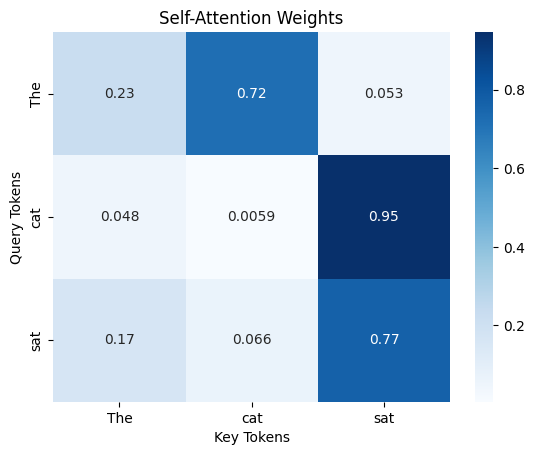

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.heatmap(weights.detach().numpy(), annot=True, cmap="Blues", xticklabels=["The", "cat", "sat"], yticklabels=["The", "cat", "sat"])
plt.title("Self-Attention Weights")
plt.xlabel("Key Tokens")
plt.ylabel("Query Tokens")
plt.show()


This heatmap shows how each token attends to the others. Diagonal dominance means the token mostly attends to itself.

## **BertViz**

Explore attention weights visualization with this interactive tutorial notebook: [BertViz Interactive Tutorial](https://colab.research.google.com/drive/1hXIQ77A4TYS4y3UthWF-Ci7V7vVUoxmQ?usp=sharing#scrollTo=T3H0qUZvPOP4)

# Positional Encoding

Transformers do **not process input tokens sequentially** (like RNNs do), so they **don’t know the order** of the input unless we explicitly tell them.

To fix this, we add **positional encodings** to token embeddings to inject information about a token’s position in the sequence.

## Basic Integer-Based Positions

We start with a very simple idea — just give each token a number representing its position:

In [6]:
import torch

seq_len = 10  # e.g., sentence with 10 tokens
positions = torch.arange(seq_len)
print("Positions:", positions)

Positions: tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


We can then turn this into an embedding:

In [7]:
import torch.nn as nn

position_embedding = nn.Embedding(num_embeddings=seq_len, embedding_dim=16)
pos_embed = position_embedding(positions)
print("Position Embeddings Shape:", pos_embed.shape)

Position Embeddings Shape: torch.Size([10, 16])


While effective, **original Transformers used sinusoidal encodings**, which we’ll implement next.

## Sinusoidal Positional Encodings

Let’s implement the **sinusoidal encoding** as described in [Vaswani et al. 2017](https://arxiv.org/abs/1706.03762).

$$
PE_{(pos, 2i)} = \sin\left(\frac{pos}{10000^{\frac{2i}{d}}}\right), \quad PE_{(pos, 2i+1)} = \cos\left(\frac{pos}{10000^{\frac{2i}{d}}}\right)
$$

In [8]:
import math
import torch

def get_sinusoidal_positional_encoding(seq_len, d_model):
    pe = torch.zeros(seq_len, d_model)
    position = torch.arange(0, seq_len, dtype=torch.float32).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
    
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    
    return pe

# Example
pos_encoding = get_sinusoidal_positional_encoding(seq_len=100, d_model=64)
print("Sinusoidal Positional Encoding Shape:", pos_encoding.shape)


Sinusoidal Positional Encoding Shape: torch.Size([100, 64])


#### Visualize Positional Encodings

Let’s plot some dimensions across different positions to see the wave patterns.

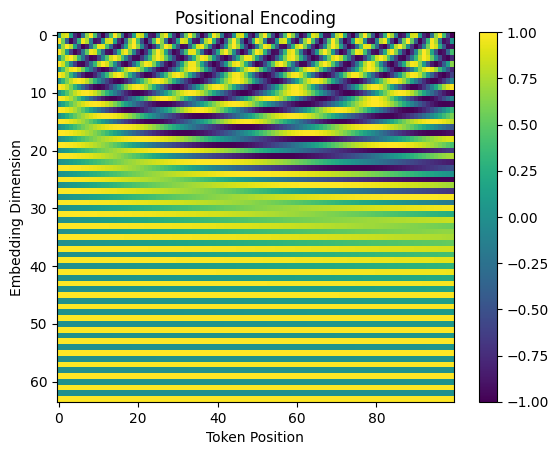

In [9]:
import matplotlib.pyplot as plt

plt.imshow(pos_encoding.T, cmap="viridis", aspect="auto")
plt.title("Positional Encoding")
plt.xlabel("Token Position")
plt.ylabel("Embedding Dimension")
plt.colorbar()
plt.show()


# Transformer Architecture Overview

Transformer models are a type of neural network architecture designed to handle sequential data by leveraging self-attention mechanisms. They excel in tasks like natural language processing and machine translation by capturing long-range dependencies and contextual relationships between tokens. The architecture was introduced in the paper ["Attention Is All You Need"](https://arxiv.org/abs/1706.03762) by Vaswani et al. (2017).

<div style="text-align: center;">
    <img src="https://machinelearningmastery.com/wp-content/uploads/2021/08/attention_research_1.png" alt="Attention Research" style="max-width: 40%; height: auto;">
</div>

Source: [machinelearningmastery.com](https://machinelearningmastery.com/wp-content/uploads/2021/08/attention_research_1.png)

## Decoder-Only Transformer

In generative AI, we often use decoder-only architectures (e.g., GPT models) to generate text one token at a time. This section walks through the key components of such a model.

### Core Components

#### 1. Embedding + Positional Encoding

Each input token is mapped to an embedding vector. Positional encoding is added to incorporate word order.

In [10]:
class TokenAndPositionalEmbedding(nn.Module):
    def __init__(self, vocab_size, d_model, max_len):
        super().__init__()
        self.token_embed = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = get_sinusoidal_positional_encoding(max_len, d_model)

    def forward(self, x):
        seq_len = x.size(1)
        token_emb = self.token_embed(x)
        pos_emb = self.pos_encoding[:seq_len, :].to(x.device)
        return token_emb + pos_emb

#### 2. Masked Multi-Head Self-Attention

Each token can only attend to earlier tokens (causal masking), enabling autoregressive generation.

In [11]:
class MaskedSelfAttention(nn.Module):
    def __init__(self, d_model, n_heads):
        super().__init__()
        # Ensure the model dimension is divisible by the number of heads
        assert d_model % n_heads == 0
        self.head_dim = d_model // n_heads  # Dimension per attention head
        self.n_heads = n_heads  # Number of attention heads

        # Linear layers for query, key, and value transformations
        self.query = nn.Linear(d_model, d_model)
        self.key = nn.Linear(d_model, d_model)
        self.value = nn.Linear(d_model, d_model)
        
        # Linear layer for the output transformation
        self.out = nn.Linear(d_model, d_model)

    def forward(self, x):
        B, T, C = x.shape  # Batch size, sequence length, and model dimension

        # Compute query, key, and value matrices and reshape for multi-head attention
        q = self.query(x).view(B, T, self.n_heads, self.head_dim).transpose(1, 2)
        k = self.key(x).view(B, T, self.n_heads, self.head_dim).transpose(1, 2)
        v = self.value(x).view(B, T, self.n_heads, self.head_dim).transpose(1, 2)

        # Compute scaled dot-product attention scores
        attn_weights = (q @ k.transpose(-2, -1)) / self.head_dim**0.5

        # Create a lower triangular mask to enforce causal masking
        mask = torch.tril(torch.ones(T, T)).to(x.device)
        attn_weights = attn_weights.masked_fill(mask == 0, float('-inf'))  # Apply mask

        # Apply softmax to get attention probabilities
        attn_probs = F.softmax(attn_weights, dim=-1)

        # Compute the weighted sum of values
        attn_out = attn_probs @ v  # Shape: (B, n_heads, T, head_dim)

        # Reshape and combine the heads
        attn_out = attn_out.transpose(1, 2).contiguous().view(B, T, C)

        # Apply the output linear transformation
        return self.out(attn_out)

#### 3. Add & Norm

Standard practice: add the input back to the output (residual) and apply layer normalization.

In [12]:
class AddNorm(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x, sublayer_output):
        return self.norm(x + sublayer_output)

#### 4. Feedforward Layer

A simple 2-layer fully connected network with non-linearity, applied to each token position independently.

In [13]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model)
        )

    def forward(self, x):
        return self.net(x)

#### 5. Putting It All Together: Transformer Decoder Block

<div style="text-align: center;">
    <img src="https://substackcdn.com/image/fetch/f_auto,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2F5024bcc5-33c9-4d53-9bd7-56cbcf9c4627_874x1108.png" alt="Transformer Decoder Block" style="max-width: 30%; height: auto;">
</div>

In [14]:
class TransformerBlock(nn.Module):
    def __init__(self, d_model, n_heads, d_ff):
        super().__init__()
        self.attn = MaskedSelfAttention(d_model, n_heads)
        self.addnorm1 = AddNorm(d_model)
        self.ff = FeedForward(d_model, d_ff)
        self.addnorm2 = AddNorm(d_model)

    def forward(self, x):
        x = self.addnorm1(x, self.attn(x))
        x = self.addnorm2(x, self.ff(x))
        return x

#### 6. Assembling the NanoTransformer (Decoder-Only)

Now we combine the embedding, positional encoding, and multiple transformer blocks into a complete **NanoTransformer** — a minimal generative language model like GPT.

In [15]:
class NanoTransformer(nn.Module):
    def __init__(self, vocab_size, d_model, n_heads, d_ff, max_len, num_layers):
        super().__init__()
        self.embed = TokenAndPositionalEmbedding(vocab_size, d_model, max_len)
        self.blocks = nn.ModuleList([
            TransformerBlock(d_model, n_heads, d_ff) for _ in range(num_layers)
        ])
        self.norm = nn.LayerNorm(d_model)
        self.output_proj = nn.Linear(d_model, vocab_size)

    def forward(self, x):
        x = self.embed(x)
        for block in self.blocks:
            x = block(x)
        x = self.norm(x)
        logits = self.output_proj(x)
        return logits

### Training the Model

We'll now train the model on a small dataset (WikiText-2) using a basic next-token prediction setup.

In [16]:
from tqdm.notebook import tqdm

import torch.optim as optim

def train(model, dataloader, vocab_size, device, epochs=5, lr=1e-4):
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in tqdm(dataloader, desc="Training Progress"):
            inputs = batch[:, :-1].to(device)
            targets = batch[:, 1:].to(device)

            logits = model(inputs)
            logits = logits.view(-1, vocab_size)
            targets = targets.view(-1)

            loss = loss_fn(logits, targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}")


####  Dataset Integration with Hugging Face

We'll use a GPT-2 tokenizer and the WikiText-2 dataset for fast experimentation

In [17]:
from datasets import load_dataset
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

dataset = load_dataset("wikitext", "wikitext-2-raw-v1", split="train")
texts = [tokenizer.encode(x["text"], truncation=True, max_length=64, padding="max_length") for x in dataset if len(x["text"]) > 0]

import torch.utils.data as data

batch_size = 32
dataloader = data.DataLoader(torch.tensor(texts), batch_size=batch_size, shuffle=True)


#### Model Hyperparameters

In [18]:
vocab_size = tokenizer.vocab_size
d_model = 32
n_heads = 1
d_ff = 256
max_len = 64
num_layers = 1

model = NanoTransformer(vocab_size, d_model, n_heads, d_ff, max_len, num_layers)

#### Training the Model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train(model, dataloader, vocab_size, device, epochs=5, lr=3e-4)

### Text Generation

In [ ]:
def generate(model, start_token, max_len=50, temperature=1.0):
    model.eval()
    input_ids = start_token.to(device)

    for _ in range(max_len):
        logits = model(input_ids)
        next_token_logits = logits[:, -1, :] / temperature
        probs = torch.softmax(next_token_logits, dim=-1)
        next_token = torch.multinomial(probs, num_samples=1)
        input_ids = torch.cat([input_ids, next_token], dim=1)

    return input_ids.squeeze().tolist()

In [23]:
start_text = "The future of AI"
input_ids = tokenizer.encode(start_text, return_tensors="pt").to(device)
print("Input IDs:", input_ids.shape)

output_ids = generate(model, input_ids, max_len=50, temperature=1.0)
output_text = tokenizer.decode(output_ids)
print(output_text)

Input IDs: torch.Size([1, 4])
The future of AI asynchronous CloakTok amphstagehunt handwrittenTellBN hind discouragethypassPushSize Trance EPSDXrocal filmedsecution pleasantherenceombies eliminating Luis separationNW theft repeatingbody Ann processing phenotype Wave enum dramCommon womb Mick interchangewangadium swear Spychedel entities household McD depression


## Resources


[NanoGPT](https://github.com/karpathy/nanoGPT) by Andrej Karpathy is a tiny but powerful GPT implementation that mirrors real GPT architectures, suitable for training on real-world data.


[Transformer Explainer](https://poloclub.github.io/transformer-explainer/) an interactive visualization tool that helps users understand how transformers work.


# Hugging Face Transformers

While building transformer models from scratch provides invaluable insight, training state-of-the-art models such as GPT-2, GPT-3, or BERT from the ground up presents significant challenges:

* **Scale**: These models contain hundreds of millions to billions of parameters.
* **Compute Requirements**: Training typically demands access to multiple high-end GPUs or TPUs.
* **Optimization Complexity**: Careful tuning of learning rates, optimizers, and distributed strategies is necessary.
* **Instability**: Training large models is prone to issues such as divergence, overfitting, or slow convergence.

The Hugging Face Transformers library offers a high-level, standardized interface to work with modern transformer-based models.

**Key Advantages**
* **Pretrained Models**: Easily load models trained on massive corpora (e.g., GPT-2, BERT, T5).
* **Tokenizer Integration**: Consistent preprocessing with AutoTokenizer.
* **Unified Interfaces**: Standard APIs for training (Trainer), evaluation, and inference.
* **Scalability**: Supports distributed training, mixed precision, and integration with 🤗 Accelerate.

## Text Generation with GPT-2

### Load a Pretrained Model and Tokenizer

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM

model_name = "distilgpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

### Generate Text from a Prompt

In [ ]:
import torch

prompt = "In the future, AI will"
inputs = tokenizer(prompt, return_tensors="pt")

# Generate text
outputs = model.generate(
    inputs["input_ids"],
    attention_mask=inputs["attention_mask"],
    pad_token_id=tokenizer.eos_token_id,
    max_length=50,
    temperature=1.0,
    top_k=50,
    top_p=0.95,
    do_sample=True,
    num_return_sequences=1
)

# Decode and print
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

In the future, AI will likely shape our world in profound and unexpected ways.  

**The rise of sophisticated AI systems – from personalized assistants to autonomous vehicles – will automate many tasks currently performed by humans.** This will drive productivity gains, potentially


**Note**: `temperature`, `top_k`, and `top_p` control the creativity and diversity of the output.

## Use a Pipeline

The `transformers.pipeline` API abstracts away the complexity of loading models and tokenizers separately. It provides a simple, high-level interface for common tasks like text generation, sentiment analysis, and more. This allows you to get started quickly without needing to manage tokenization, model configuration, or output decoding manually.

In [1]:
from transformers import pipeline

pipe = pipeline("text-generation", model="google/gemma-3-1b-it", device='cpu')
pipe("In the future, AI will")

Device set to use cpu


[{'generated_text': 'In the future, AI will be intimately woven into the fabric of daily life, automating tasks, generating insights, and predicting outcomes with'}]

# Resources

[NanoGPT](https://github.com/karpathy/nanoGPT/blob/master/model.py)

[Let's build GPT: from scratch, in code, spelled out.](https://www.youtube.com/watch?v=kCc8FmEb1nY)

[The Illustrated Transformer](https://jalammar.github.io/illustrated-transformer/)